(rv)=

# Radial velocity fitting

In [1]:
import exoplanet

Fitting RVs for Earth and Jupiter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate_data import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)


# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(45.0)
m_earth = 1 #units m_earth



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278
omega_jup = np.radians(274.3)
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.304) + inclination_earth
m_jup = 317.83 #units m_earth


P_nep = 59758.97 
e_nep = 0.00859
Tper_nep = 2468662.5000000
omega_nep = np.radians(273.2)
Omega_nep = np.radians(131.784)
inclination_nep = np.radians(1.7700) + inclination_earth
m_nep = 17.204 #units m_earth5.9724



P_saturn = 10739.58 
e_saturn = 0.0539
Tper_saturn = 2452832.0625000
omega_saturn = np.radians(338.9)
Omega_saturn = np.radians(113.7)
inclination_saturn = np.radians(2.486) + inclination_earth
m_saturn = 95.159 #units m_earth




/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:291: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:359: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


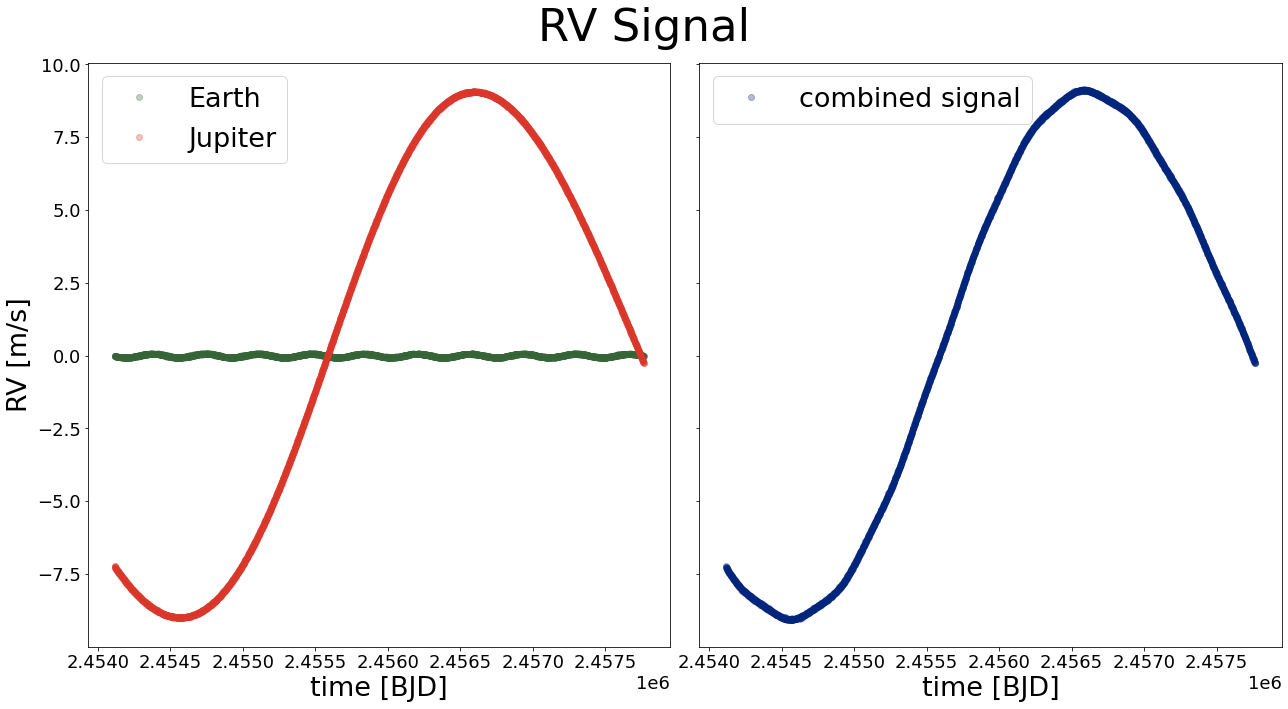

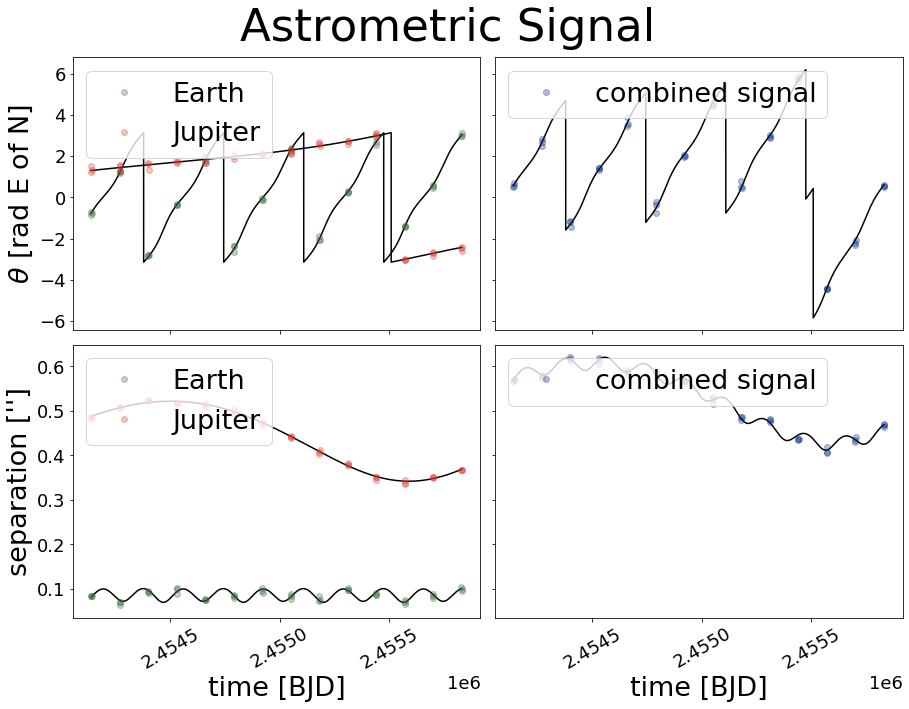

In [3]:
orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]
orbit_params_saturn = [P_saturn, e_saturn, Tper_saturn, omega_saturn, Omega_saturn, inclination_saturn, m_saturn]
orbit_params_nep = [P_nep, e_nep, Tper_nep, omega_nep, Omega_nep, inclination_nep, m_nep]

orbit_params = [orbit_params_earth, orbit_params_jup]

times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1825):
    if ii % 130 == 0:
        times_observed_astrometry.append(ii-1)
        times_observed_astrometry.append(ii)
        times_observed_astrometry.append(ii+1)

n_planets = 2
t_dur_rv = 3650
n_obs_rv = 3000
sigma_rv = 0.01

sigma_theta = 0.1
sigma_rho = 0.005
plx = 0.1


simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'],
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )



<ErrorbarContainer object of 3 artists>

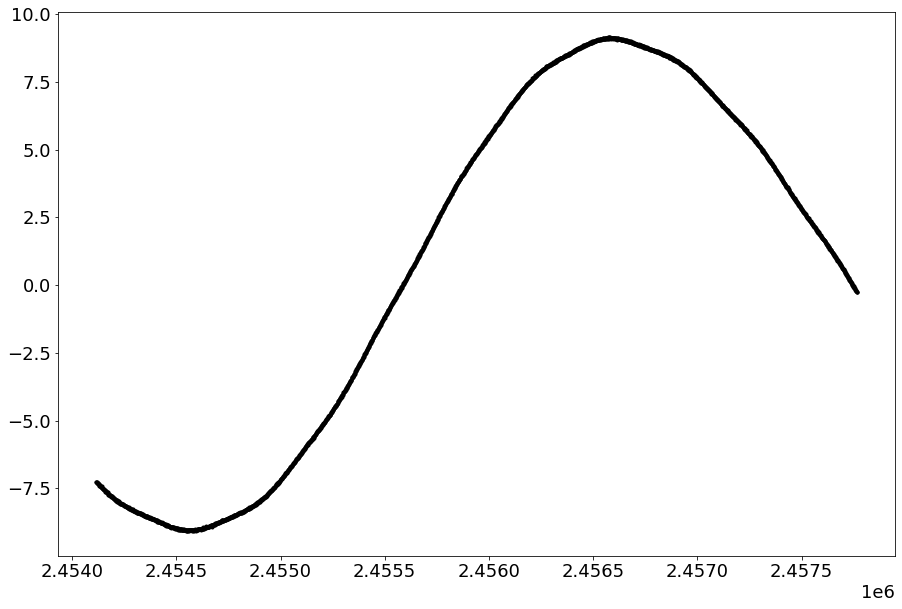

In [4]:
times, rv_results, theta_results, rho_results = simulate_data(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
     [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
     [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
     [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = times, rv_results, theta_results, rho_results





x_rv = times_observed_rv
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), .01)


# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


plt.figure(figsize=[15,10])
plt.errorbar(x_rv,y_rv, yerr=y_rv_err, ls = '', marker = '.', color = 'k')

We will have a sense of the periods of the planets, so we can use the `exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [198]:
periods = [365.3, 4327.5]
period_errs = [1, 5]
t0s = [2454115.58958191, 2457740.80985712]
t0_errs = [5, 5]
Ks = xo.estimate_semi_amplitude(periods, x_rv, y_rv, y_rv_err, t0s=t0s)
print(Ks, "m/s")

[0.04746933 9.08216389] m/s


In [199]:
0.5 * (
    np.log(np.array(periods) + np.array(period_errs))
    - np.log(np.array(periods) - np.array(period_errs))
)

array([0.00273748, 0.0011554 ])

In [200]:
np.array(period_errs) / np.array(periods)


array([0.00273748, 0.0011554 ])

## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3.
First, we'll define our priors on the parameters:

In [201]:
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:
    
    ## Gaussian priors based on previous modeling
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    
    #log normal prior on period around estimates
    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sd=np.array(period_errs) / np.array(periods),
        shape=2,
        testval=np.log(periods),
    )
    P = pm.Deterministic("P", tt.exp(logP))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=2.0, shape=2, testval=np.log(Ks))
    
    K = pm.Deterministic("K", tt.exp(logK))

    # Eccentricity & argument of periasteron
    ecs = pmx.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(y_rv_err)), sd=0.01)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1))

    # Define the RVs at the observed times
    rv_model = get_rv_model(x_rv)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(y_rv_err ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

Now, we can plot the initial model:

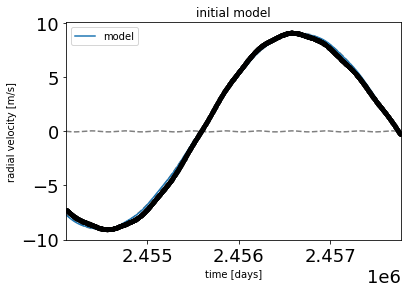

In [202]:
plt.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k")
with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It looks pretty good already, but let's still fit for the maximum a posterior parameters.

In [203]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[t0])
    map_soln = pmx.optimize(start=map_soln, vars=[logK, logP, logs])
    map_soln = pmx.optimize(start=map_soln, vars=[ecs])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [t0]


message: Optimization terminated successfully.
logp: -656479.6936002889 -> -650951.9514867084
optimizing logp for variables: [logs, logP, logK]


message: Desired error not necessarily achieved due to precision loss.
logp: -650951.9514867084 -> -33596.72765897941
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -33596.72765897941 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [logs, ecs, logK, logP, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -33596.72765897941 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


No handles with labels found to put in legend.


[2454103.02914265 2457737.89521874]


Text(0.5, 1.0, 'MAP model only')

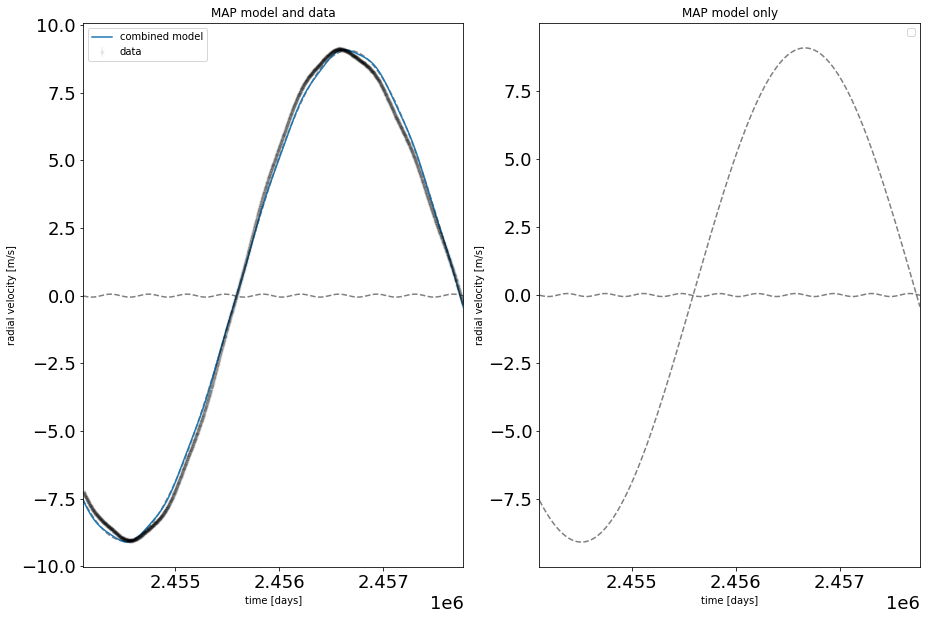

In [204]:
fig, ax = plt.subplots(1,2, figsize = [15,10])
print(map_soln['t0'])

ax[0].errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data')
ax[0].plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
ax[0].plot(t, map_soln["rv_model_pred"], label="combined model")

ax[0].legend(fontsize=10)
ax[0].set_xlim(t.min(), t.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("MAP model and data")


ax[1].plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
ax[1].legend(fontsize=10)
ax[1].set_xlim(t.min(), t.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
ax[1].set_title("MAP model only")


That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use the `pmx.sample` function from [pymc3-ext](https://github.com/exoplanet-dev/pymc3-ext) which wraps `pm.sample` function with some better defaults and tuning strategies.

In [205]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, ecs, logK, logP, t0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 472 seconds.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [206]:
import arviz as az

az.summary(
    trace, var_names=["logs", "omega", "ecc", "t0", "logK", "P"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logs,-4.601,0.009,-4.618,-4.584,0.000,0.000,2516.0,2516.0,2514.0,1485.0,1.00
omega[0],1.029,0.942,-0.659,2.958,0.025,0.020,1427.0,1071.0,1263.0,1202.0,1.00
omega[1],-1.496,0.001,-1.498,-1.494,0.000,0.000,2399.0,2399.0,2399.0,1417.0,1.00
ecc[0],0.010,0.006,0.000,0.019,0.000,0.000,1279.0,1279.0,1214.0,1391.0,1.00
ecc[1],0.048,0.000,0.048,0.049,0.000,0.000,2729.0,2729.0,2729.0,1374.0,1.01
t0[0],2454102.902,0.893,2454101.287,2454104.630,0.020,0.014,1907.0,1897.0,1907.0,1628.0,1.00
t0[1],2457740.800,0.089,2457740.629,2457740.956,0.002,0.001,2926.0,2926.0,2873.0,1621.0,1.00
logK[0],-2.763,0.006,-2.774,-2.751,0.000,0.000,2789.0,2789.0,2804.0,1405.0,1.00
logK[1],2.200,0.000,2.200,2.200,0.000,0.000,2210.0,2210.0,2215.0,1303.0,1.00
P[0],365.190,0.115,364.954,365.386,0.002,0.002,2211.0,2211.0,2231.0,1557.0,1.00


array([[<AxesSubplot:title={'center':'logs'}>,
        <AxesSubplot:title={'center':'logs'}>],
       [<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'P'}>],
       [<AxesSubplot:title={'center':'logK'}>,
        <AxesSubplot:title={'center':'logK'}>],
       [<AxesSubplot:title={'center':'ecc'}>,
        <AxesSubplot:title={'center':'ecc'}>],
       [<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'omega'}>]], dtype=object)

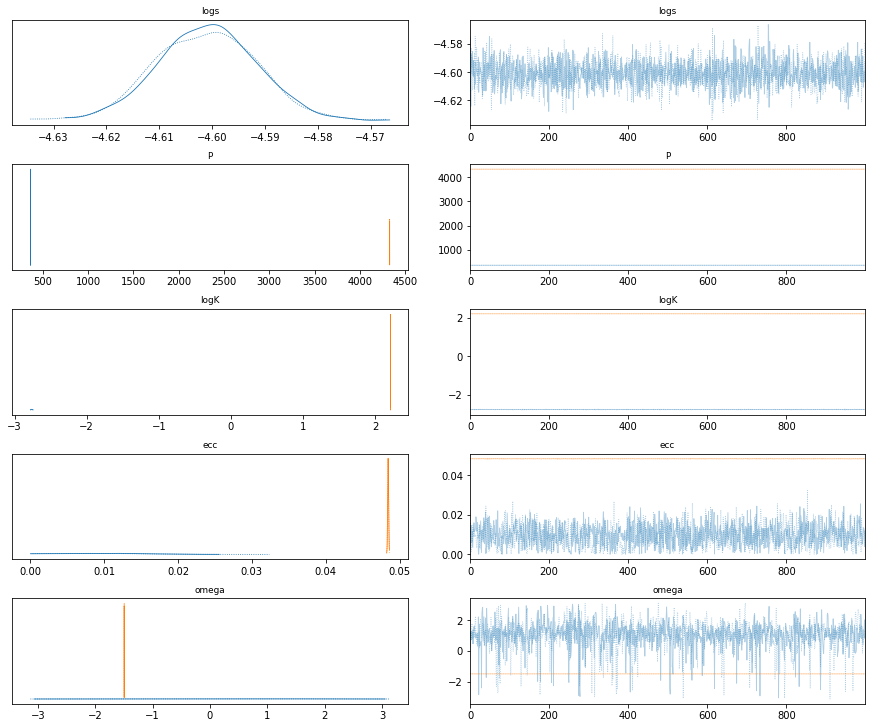

In [207]:
pm.traceplot(trace, var_names=["logs", "P", "logK", "ecc", "omega"])


It looks like everything is pretty much converged here. 

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

In [208]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

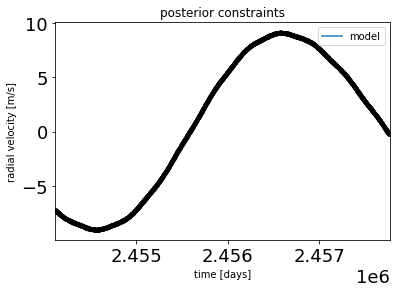

In [209]:
plt.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k")

# Compute the posterior predictions for the RV model
rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

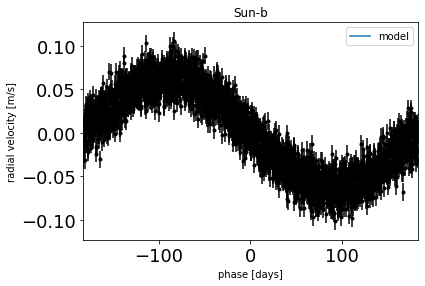

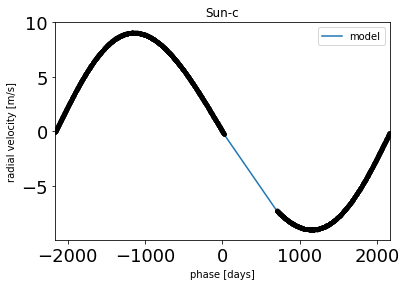

In [210]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace.posterior["P"].values[:, :, n])
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(
        trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
    )

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=y_rv_err, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        trace.posterior["vrad_pred"].values[:, :, inds, n],
        [16, 50, 84],
        axis=(0, 1),
    )
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("Sun-{0}".format(letter))

In [251]:
parameters = ["P", "K", "ecc", "omega", "t0"]
param_medians = {}
posterior1 = {}
posterior2 = {}
for param in parameters:
    print(param + " median")
    planet1_med = np.median(trace.posterior[param].values[:, :, 0])
    planet2_med = np.median(trace.posterior[param].values[:, :, 1])
    print(planet1_med)
    print(planet2_med)
    
    param_medians[param]=[planet1_med, planet2_med]
    print("")

P median
365.1928517802711
4327.890490225911

K median
0.06310602596973844
9.021860551983433

ecc median
0.009386489135304224
0.04845480226202101

omega median
1.130505486896454
-1.4961501533304498

t0 median
2454102.8986692326
2457740.799371318



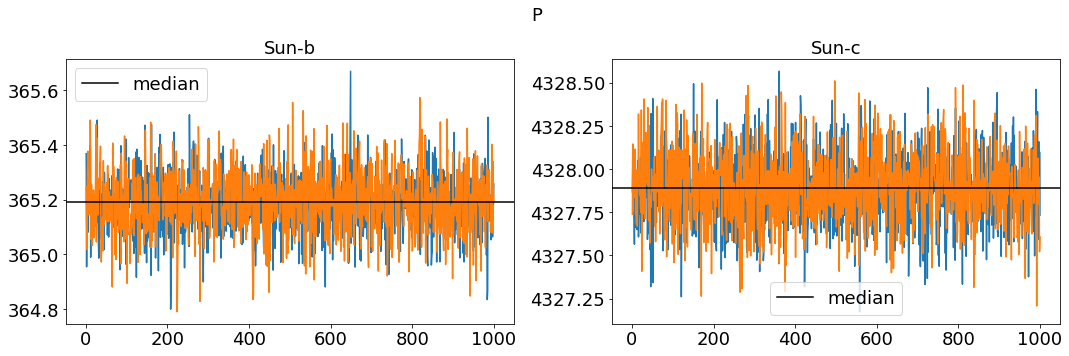

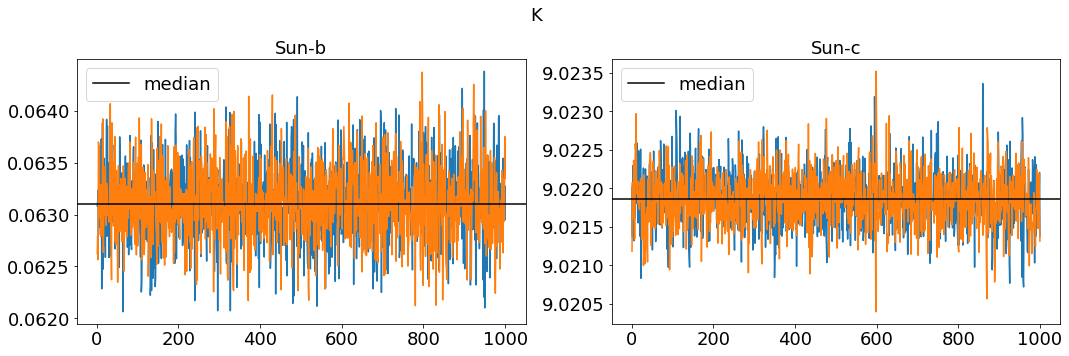

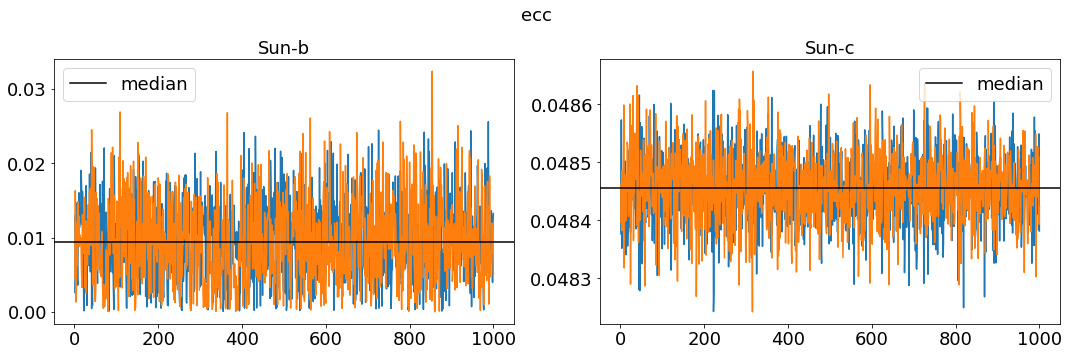

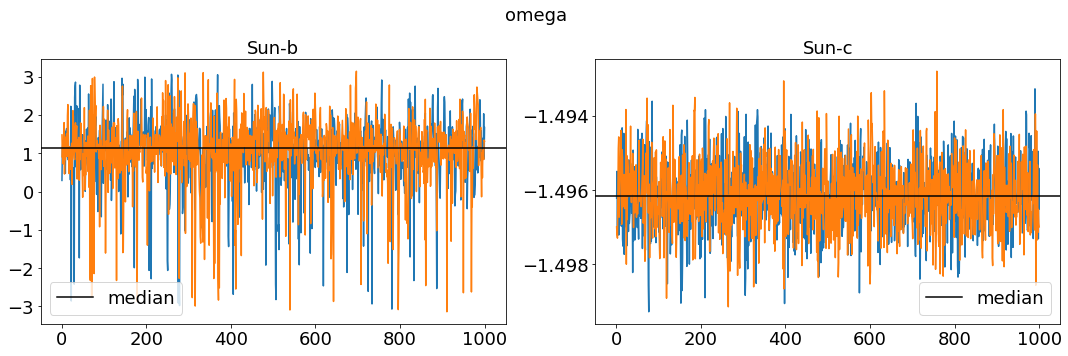

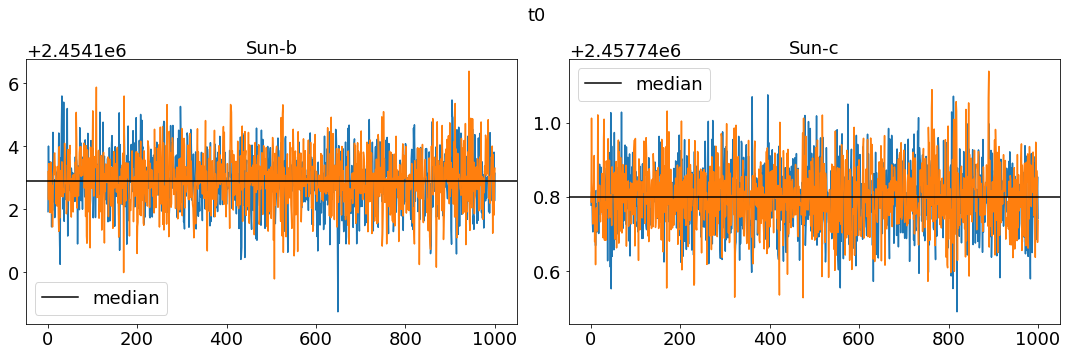

In [262]:
parameters = ["P", "K", "ecc", "omega", "t0"]
for param in parameters:
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    planet1_chain1 = trace.posterior[param].values[:, :, 0][0]
    planet1_chain2 = trace.posterior[param].values[:, :, 0][1]
    
    planet2_chain1 = trace.posterior[param].values[:, :, 1][0]
    planet2_chain2 = trace.posterior[param].values[:, :, 1][1]
    
    
    nstep = np.arange(1, len(chain1)+1, 1)
    
    
    ax[0].plot(nstep, planet1_chain1)
    ax[0].plot(nstep, planet1_chain2)
    ax[0].axhline(y=param_medians[param][0], color = 'k', label = 'median')
    ax[0].set_title("Sun-b", fontsize = 18)
    ax[0].legend(fontsize = 18)
    
    ax[1].plot(nstep, planet2_chain1)
    ax[1].plot(nstep, planet2_chain2)
    ax[1].axhline(y=param_medians[param][1], color = 'k', label = 'median')
    ax[1].set_title("Sun-c", fontsize = 18)
    ax[1].legend(fontsize = 18)

    fig.suptitle(param, fontsize = 18)
    fig.tight_layout()
    plt.show()